# Stochastic Optimal Control

Finding globally optimal control policy by numerically solving the full Bellman Optimality Equation with bounded controls.

One needs to define 
- state-space $\mathbb(S)$
- action-space $\mathbb(A)$
- dynamic system $b(s,a)$
- density of reward function per unit of time $R(s,a)$
- discounting factor per unit of time $\gamma$
- (optionally) absorber region

---

In this example we are going to use modified Inversed Pendulum system
 - non-periodic state space
 - severely underpowered controls (can reach far states only by exploiting internal resonance of the pendulum)

It is a small-dimensional system solution of which can easily be verified on full uncompressed tensors (without Tensor Train compression).

In [118]:
import sys
sys.path.append("..")

import machinespirit as ms
import tt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def universal_reward(s, a, dynsys=None):  # per unit of time!
    if dynsys:
        s = s.reshape(dynsys.S.D, -1)
        a = a.reshape(dynsys.A.D, -1)
    x, p = s
    cx = 1e-3
    cp = 1e-3
    ca = 0.1
    timecost = 1.0
    ans = -cx * (x-np.pi)**2 - cp * p**2 - ca * a**2 - timecost
    return ans.reshape(-1,1)

prox = 0.05
absorber = np.array([[np.pi-prox, np.pi+prox], [-prox, prox]])

# S = ms.Box(N_cores=[[101],[301]], bounds = [[-np.pi, np.pi],[-3*np.pi, 3*np.pi]])
dynsys = ms.Dynsystems.pend3(R_fun=universal_reward, absorber=absorber, gamma=1-2e-3)
solver = ms.Solver(dynsys=dynsys, RMAX=60, fastmixing=False, tol=1e-6, adaptive_coef=1/3.)

cooking absorber function from boundaries


In [207]:
solver.VI(maxit=2500, typeOfIteration='QI', relerr_goal=5e-6, rounding_in_VI=False, verbose=False)

KeyboardInterrupt: 

### Convergence of solution

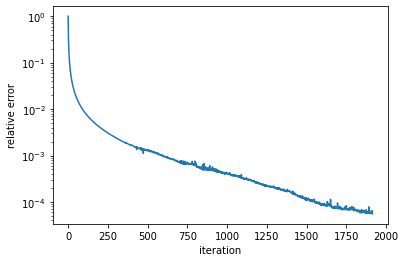

In [208]:
errors = solver.errs[1:]

plt.semilogy( errors)
plt.xlabel('iteration')
plt.ylabel('relative error');

## Value Function

In [209]:
def plot_in_statespace(data, S: ms.Box, cmap=None):
    plt.figure(figsize=(10,3))
    plt.imshow(data, extent=dynsys.S.bounds.flatten()/np.pi, cmap=cmap)
    plt.xlabel('$\phi$ / $\pi$')
    plt.ylabel('$\dot \phi$ / $\pi$')
    plt.colorbar()

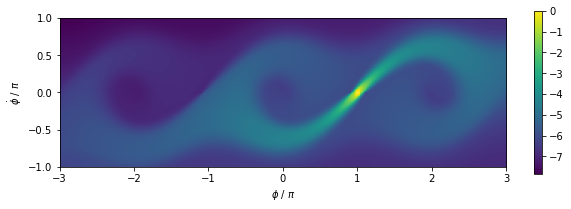

In [210]:
data = solver.V.full().T
plot_in_statespace(data, dynsys.S)

## Policy Function

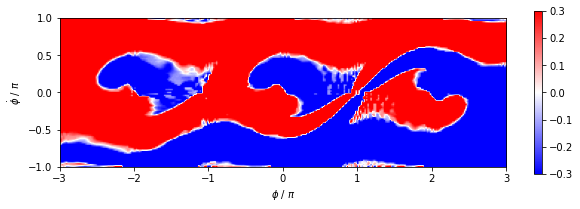

In [213]:
solver.make_Policy_from_Q_argmax_full()
data = solver.Policy.T
plot_in_statespace(data, dynsys.S, cmap='bwr')

In [214]:
import sdeint
def CreateTrajectory(
        self,
        s0,
        policyfun=None,
        testnoise=0,
        timespan=10,
        plot_timeseries=False,
        Nstoch=1,
        sde_dt=None,
    ):
        # policy_fun is such that u=policy_fun(s)  such that b(s, policy_fun(s))
        # does not crash
        if policyfun is None:
            print("No policy is specified. Using policy of zeros")
            policyfun = self.policyfun_zero

        if sde_dt is None:
            # danger danger
            sde_dt = timespan / 1000.0

        if self.type == "SDE":
            TsSDE = np.arange(0, timespan, sde_dt, dtype=np.float64)
            trajectories = []
            b = self.b_fun

            for i in range(Nstoch):
                trajectories.append(
                    sdeint.itoSRI2(
                        lambda s, t: b(s, policyfun(s)),
                        lambda s, t: testnoise * np.eye(s.shape[0]),
                        np.array(s0, dtype=np.float),
                        TsSDE,
                    )
                )

            trajectories = np.array(trajectories)

            if plot_timeseries:
                self.PlotTimeseries(trajectories, TsSDE)

            return trajectories, TsSDE
        else:
            raise NotImplementedError(
                "Simulator for non-SDE envinronments is not implemented"
            )

In [222]:
s0 = np.array([-2.*np.pi, 0.], dtype=np.float)
timespan = 50.

sde_dt = timespan / 2000
TsSDE = np.arange(0, timespan, sde_dt, dtype=np.float64)

b = dynsys.b_fun

# policyfun = dynsys.policyfun_zero
policyfun = solver.policyfun_fromPolicy

testnoise = 1e-2

traj = sdeint.itoSRI2(
                    lambda s, t: np.array(b(s, policyfun(s)), dtype=np.float),
                    lambda s, t: testnoise * np.eye(s.shape[0]),
                    np.array(s0, dtype=np.float),
                    TsSDE,
                )

/tmp/ipykernel_85398/1018287084.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  s0 = np.array([-2.*np.pi, 0.], dtype=np.float)
/tmp/ipykernel_85398/1018287084.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(s0, dtype=np.float),
/home/ab/Documents/ttcontrol/examples/../machinespirit/Dynsystems/_Pendulums.py:12: VisibleDep

Text(0, 0.5, '$\\phi$ / $\\pi$')

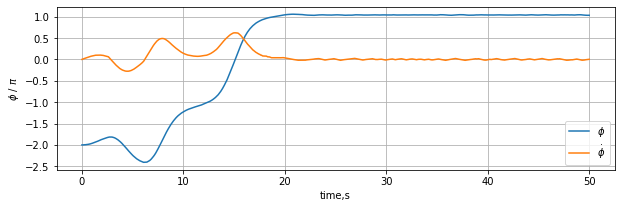

In [223]:
plt.figure(figsize=(10,3))
plt.plot(TsSDE,traj/np.pi)
plt.grid()
plt.legend(['$\phi$', '$\dot \phi$'])
plt.xlabel('time,s')
plt.ylabel('$\phi$ / $\pi$')